In [20]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import numpy as np

In [9]:
cleaned_df = pd.read_csv('../data/cleaned_tweet_data.csv')
cleaned_df = cleaned_df.fillna("")

In [ ]:
stopwords_english = stopwords.words('english')

In [4]:
def text_category(p: float) -> str:
    if p > 0:
        return "positive"
    elif p == 0:
        return "neutral"
    else:
        return "negative"

In [24]:
cleaned_df['polarity'] = cleaned_df['polarity'].apply(pd.to_numeric)
cleaned_df['score'] = cleaned_df['polarity'].apply(text_category)
cleaned_df['score'].value_counts()

neutral     7422
positive    6278
negative    2685
Name: score, dtype: int64

### Sentiment Analysis

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

### Plot distribution of data

In [25]:
cleaned_df['score'] = cleaned_df['polarity'].apply(text_category)
cleaned_df['score'].value_counts()

neutral     7422
positive    6278
negative    2685
Name: score, dtype: int64

<AxesSubplot:title={'center':'score'}>

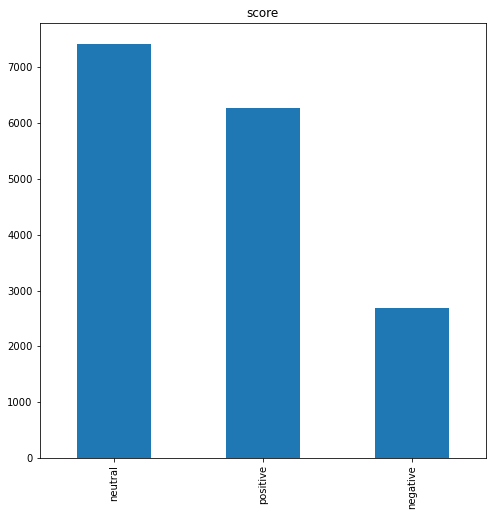

In [26]:
score_count =  cleaned_df['score'].value_counts()
score_count.plot(kind="bar", y="score", title="score", figsize=[8, 8])

In [27]:
def remove_neutral(value):
    return value != "neutral"

In [28]:
stemmer = PorterStemmer()
def stem_word(text: str) -> str:
    
    stemmed_words = []
    sent_list = text.split()
    
    for word in sent_list:
        try:
            stemmed_words.append(stemmer.stem(word)) 
        except:
             stemmed_words.append(word)
    return ' '.join(stemmed_words)

In [29]:
cleanedTweet = cleaned_df[cleaned_df['score'].map(remove_neutral)]
cleanedTweet['score_map'] = cleanedTweet["score"].map( lambda score: 1 if score == "positive" else 0)
cleanedTweet['clean_text'] = cleanedTweet['clean_text'].apply(stem_word)

/tmp/ipykernel_21190/1634712725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedTweet['score_map'] = cleanedTweet["score"].map( lambda score: 1 if score == "positive" else 0)
/tmp/ipykernel_21190/1634712725.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedTweet['clean_text'] = cleanedTweet['clean_text'].apply(stem_word)


In [30]:
(X, y) = cleanedTweet['clean_text'], cleanedTweet['score_map']

In [31]:
trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
trigram_vectorizer.fit(X.values)

CountVectorizer(ngram_range=(1, 3))

In [32]:
X_trigram = trigram_vectorizer.transform(X.values)

In [33]:
trigram_tf_idf_transformer = TfidfTransformer()
trigram_tf_idf_transformer.fit(X_trigram)

TfidfTransformer()

In [34]:
X_train_tf_idf = trigram_tf_idf_transformer.transform(X_trigram)

### Model training

In [35]:
def train_and_show_scores(X, y, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [36]:
train_and_show_scores(X_trigram, y, title="trigram")

trigram
Train score: 1.0 ; Validation score: 0.85



In [37]:
train_and_show_scores(X_train_tf_idf, y, title="trigram_tf_idf")

trigram_tf_idf
Train score: 1.0 ; Validation score: 0.84

